# User Session EDA

This notebook details the search for trends that may lend themselves to produce a model that can predict visitor revenue.  The features explored here are considered with an emphasis on how users interact with a site, rather than how the business reaches out to the audience (these are not independent problems, but thematically different, though arguably in a trivial way).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from datetime import datetime

from helpers import *

%matplotlib inline

from bokeh.plotting import figure
from bokeh.layouts import WidgetBox, column, row
from bokeh.models.widgets import Button
from bokeh.models.widgets.sliders import Slider
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.io import show, output_notebook

from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application

output_notebook()

Loading BokehJS ...

In [2]:
with open('credentials.txt') as f:
    path = f.read()
    
engine = sqlalchemy.create_engine(path)

In [3]:
query = """
WITH top_spender AS (
    SELECT fullVisitorId
    FROM train_data
    GROUP BY fullVisitorId
    HAVING SUM(CAST(totals ->> 'transactionRevenue' AS NUMERIC)) > 1
    ORDER BY SUM(CAST(totals ->> 'transactionRevenue' AS NUMERIC))  DESC
    LIMIT 100
) SELECT *
FROM train_data
WHERE fullVisitorID IN (SELECT fullVisitorId FROM top_spender)
ORDER BY fullVisitorId, visitStartTime
"""

top_spender = pd.read_sql_query(query, engine)
top_spender = dictUnravel(top_spender)
top_spender = visitFix(top_spender)

OperationalError: (psycopg2.OperationalError) could not connect to server: Connection refused
	Is the server running on host "localhost" (::1) and accepting
	TCP/IP connections on port 5432?
could not connect to server: Connection refused
	Is the server running on host "localhost" (127.0.0.1) and accepting
	TCP/IP connections on port 5432?
 (Background on this error at: http://sqlalche.me/e/e3q8)

In [4]:
query = """
    SELECT fullVisitorId, SUM(CAST(totals ->> 'transactionRevenue' AS NUMERIC)) AS revSum
    FROM train_data
    GROUP BY fullVisitorId
    HAVING SUM(CAST(totals ->> 'transactionRevenue' AS NUMERIC)) > 1
    ORDER BY SUM(CAST(totals ->> 'transactionRevenue' AS NUMERIC))  DESC
    LIMIT 100
"""

top_order = pd.read_sql_query(query, engine)

In [5]:
with open('./pickles/top_spender.pkl', 'wb') as f:
    pickle.dump(top_spender, f)

In [6]:
with open('./pickles/top_order.pkl', 'wb') as f:
    pickle.dump(top_order, f)

In [4]:
#Alternatively, just load this,
with open('./pickles/top_spender.pkl', 'rb') as f:
    top_spender = pickle.load(f)
    
with open('./pickles/top_order.pkl', 'rb') as f:
    top_order = pickle.load(f)

In [5]:
channel_color = {'Organic Search':'goldenrod',
                 'Display':'blue',
                 'Referral':'green',
                 'Affiliates':'orange',
                 'Paid Search':'navy',
                 'Direct':'firebrick',
                 'Social':'olive',
                 '(Other)':'yellow'
                }

In [6]:
top_spender = top_spender.assign(color = lambda df: df['channelgrouping'].map(lambda x: channel_color[x]),
                                 size = lambda df: df['pageviews'].map(lambda x: 5*np.log(x+1))
                                )

Rather than attempting to visualize user information in summary, user activity in the training data is plotted below interactively.  The indices are ordered by total transaction revenue across all sessions.

In [7]:
def modDoc(doc):
    
    def makeSource(id_index):
        temp = top_spender.query(f'fullvisitorid=="{top_order.iloc[id_index,0]}"')
        return ColumnDataSource(temp)
    
    def makePlot(source, id_index):
        xmin = source.data['visitstarttime'].min()
        xmax = source.data['visitstarttime'].max()
        ymax = source.data['transactionRevenue'].max()
    
        p = figure(
            x_range=(datetime(2016,7,1), datetime(2017,9,1)), 
            y_range=(-0.1*ymax, 1.1*ymax),
            x_axis_type='datetime',
            title = 'Top Spenders (Size ~ Page Views)'
        )

        points = p.circle(x='visitstarttime', y='transactionRevenue', source=source, fill_color='color', size='size', alpha=0.3, legend='channelgrouping')
        
        return p
    
    source = makeSource(0)
    p = makePlot(source, 0)
    p.yaxis.axis_label = "Transaction Revenue"
    p.add_tools(HoverTool(tooltips=[
        ('Channel','@channelgrouping'),
        ('True Direct', '@isTrueDirect'),
        ('Revenue', '@transactionRevenue'),
        ('Domain', '@networkDomain'),
        ('Sub Continent', '@subContinent'),
        ('Page Views', '@pageviews')
    ]))
    
    index = 0
    
    def slideUpdate(attr, old, new):
        index = slider.value
        new_src = makeSource(index)
        source.data.update(new_src.data)
    
    slider = Slider(
        start=0, 
        end=99, 
        step=1, 
        value=0, 
        title='User Index'
    )
    slider.on_change('value', slideUpdate)
    
    widgets = WidgetBox(slider)
    layout = row(widgets, p)
    doc.add_root(layout)

handler = FunctionHandler(modDoc)
app = Application(handler)
show(app)

We immediately see that the top spender is indeed an outlier, the same one to cause a spike in average transaction amount for network domain and the display channel.  It can also be confirmed that this is also the user causing a spike in the users that complete 16 transactions.

There is no single consistent pattern in the top spenders, even ignoring the index 0 outlier.  We see similar behaviors among certain groups of users; for instance, users 15 and 19 show a large amount of activity in short bursts.  There are no obvious universal trends, at least, and factors such as activity density or total page views should be compared to the most active visitors who spend no money before any conclusion can be made.

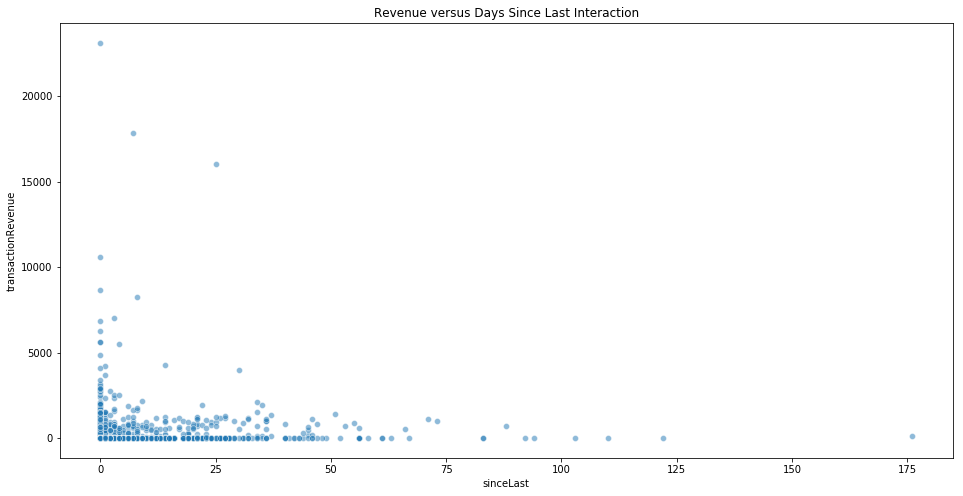

In [11]:
plt.figure(figsize=(16,8))
sns.scatterplot(
    x = 'sinceLast',
    y = 'transactionRevenue',
    data = top_spender.sort_values(['fullvisitorid', 'visitstarttime'])\
    .assign(sinceLast = lambda df: df.groupby('fullvisitorid').visitstarttime.diff().map(lambda x: x.days)),
    alpha = 0.5
)
plt.title('Revenue versus Days Since Last Interaction');

Generally, the likelihood of purchase dies off exponentially with time spent away from the site.  This is not surprising, given most of the business is made up of visitors who only make one purchase.

In [12]:
query = """
WITH lookers AS (
    SELECT fullVisitorId, 
        MAX(visitNumber) AS visitNumber,
        SUM(visitNumber) AS visitSum,
        SUM(CAST(totals ->> 'pageviews' AS NUMERIC)) AS views,
        AVG(COALESCE(CAST(totals ->> 'bounces' AS NUMERIC), 0)) AS bounceRate,
        SUM(CAST(totals ->> 'transactionRevenue' AS NUMERIC)) AS transactionRevenue
    FROM train_data
    GROUP BY fullVisitorId
    HAVING SUM(CAST(totals ->> 'transactionRevenue' AS NUMERIC)) IS NULL
)
SELECT *
FROM lookers
"""

non_spenders = pd.read_sql_query(query, engine)

In [13]:
query = """
WITH spenders AS (
    SELECT fullVisitorId, 
        MAX(visitNumber) AS visitNumber,
        SUM(visitNumber) AS visitSum,
        SUM(CAST(totals ->> 'pageviews' AS NUMERIC)) AS views,
        AVG(COALESCE(CAST(totals ->> 'bounces' AS NUMERIC), 0)) AS bounceRate,
        SUM(CAST(totals ->> 'transactionRevenue' AS NUMERIC)) AS transactionRevenue
    FROM train_data
    GROUP BY fullVisitorId
    HAVING SUM(CAST(totals ->> 'transactionRevenue' AS NUMERIC)) IS NOT NULL
)
SELECT *
FROM spenders
"""

spenders = pd.read_sql_query(query, engine)

In [14]:
spenders.sort_values('visitnumber', ascending=False).head(20).views.std()

877.4445191637625

In [15]:
non_spenders.sort_values('visitnumber', ascending=False).head(20).views.std()

674.0593914173251

Even among the most active visitors who do not make a purchase, the average number of pageviews is much lower than that of users who end up making purchases.  However, the standard deviation of these groups is larger than the means themselves.  Trying to distinguish 

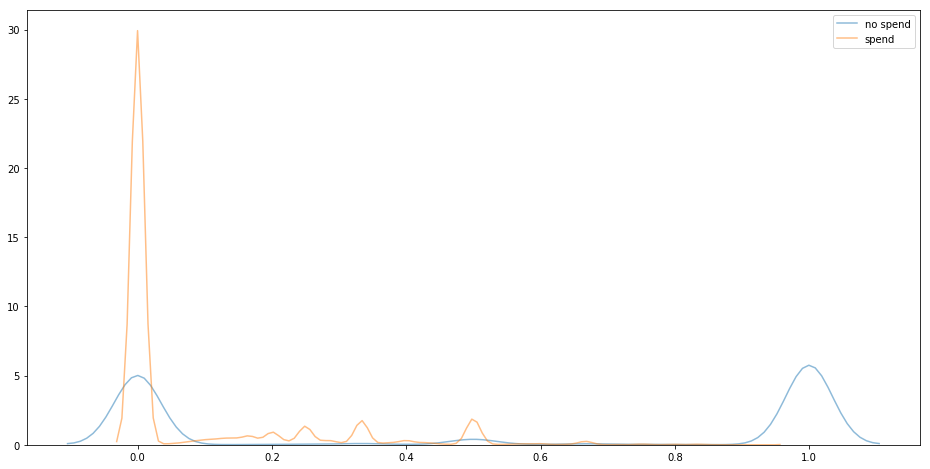

In [16]:
plt.figure(figsize=(16,8))
sns.kdeplot(non_spenders.bouncerate, label='no spend', alpha=.5)
sns.kdeplot(spenders.bouncerate, label = 'spend', alpha=.5)

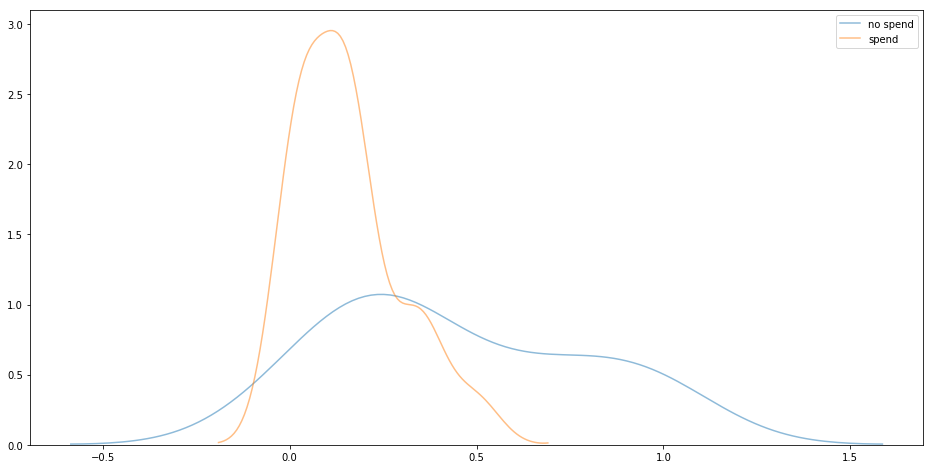

In [17]:
plt.figure(figsize=(16,8))
sns.kdeplot(non_spenders.sort_values('visitnumber', ascending=False).head(20).bouncerate, label='no spend', alpha=.5)
sns.kdeplot(spenders.sort_values('transactionrevenue', ascending=False).head(20).bouncerate, label = 'spend', alpha=.5)

The absolute top spenders follow a different distribution.  These users have a larger portion of the group at a very low bounce rate.  We can have confidence that we can probably separate top spenders from the most active non-spenders, and definitely from the less active ones with bounce rates either zero or one.  This could be a feature in a model that aggregates user statistics.  Further, this distribution does not change in the test set.  The effect of this feature should be consistent across time.

In [18]:
non_spenders.query('visitnumber > 1').shape

(92443, 6)

In [19]:
non_spenders.shape

(704171, 6)

In [20]:
spenders.query('visitnumber > 1').shape

(7033, 6)

In [21]:
spenders.shape

(9996, 6)

In [22]:
spenders.query('visitnumber > 1 and bouncerate > 0').shape

(2566, 6)

Most of those that spend have a bounce rate of zero and a correspondingly low number of visits.  They still make up a sizeable portion of all sales, though.  We arbitrarily look at users with less than 10 visits and a bounce rate of zero to demonstrate this fact.

In [23]:
spenders.query('visitnumber < 10 and bouncerate == 0').transactionrevenue.sum()/spenders.transactionrevenue.sum()

0.49908726949540333

In [24]:
query = """
WITH test AS (
    SELECT fullVisitorId, 
        MAX(visitNumber) AS visitNumber, 
        SUM(CAST(totals ->> 'pageviews' AS NUMERIC)) AS views,
        AVG(COALESCE(CAST(totals ->> 'bounces' AS NUMERIC), 0)) AS bounceRate
    FROM test_data
    GROUP BY fullVisitorId
)
SELECT *
FROM test
"""

testers = pd.read_sql_query(query, engine)

In [25]:
testers.head()

,fullvisitorid,visitnumber,views,bouncerate
0,0000000259678714014,2,13.0,0.0
1,0000049363351866189,3,3.0,1.0
2,0000053049821714864,1,1.0,1.0
3,0000059488412965267,3,3.0,1.0
4,0000085840370633780,1,2.0,0.0


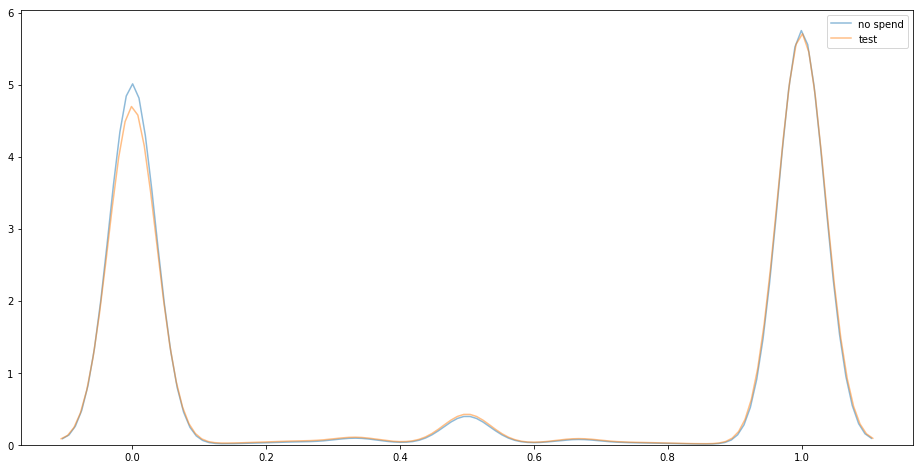

In [26]:
plt.figure(figsize=(16,8))
sns.kdeplot(non_spenders.bouncerate, label='no spend', alpha=.5)
sns.kdeplot(testers.bouncerate, label='test', alpha=.5)

It probably is not surprising to find that the test set follows the training data's non-spenders very closely.  There is a smaller amount of users who have a bounce rate of zero, however.  Still, it is also encouraging to see that the test data does not differ in this general distribution the next year.  The modes between the extremes in the training data should be further dissected to find what differentiates these users, hopefully still on this aggregate level.

Confident in this feature's predictive ability, we move on to modeling.